In [1]:
import os
from dotenv import load_dotenv

load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")
tavily_api_key = os.getenv("TAVILY_API_KEY")

In [2]:
from typing import Annotated, Dict, List, TypedDict, Any, Optional
from langchain.document_loaders import PyPDFLoader  # PDF 파일 로더 사용
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.retrievers import BM25Retriever
from langchain.retrievers import EnsembleRetriever
from langchain_openai import OpenAIEmbeddings
from kiwipiepy import Kiwi

kiwi = Kiwi()

# kiwi 토크나이징 함수
def kiwi_tokenize(text: str) -> List[str]:
    """
    Tokenizes the input text using the Kiwi tokenizer.
    """
    tokens = kiwi.tokenize(text)
    return [token.form for token in tokens if token.tag != "SPACE"]

pdf_file = "PEAK_internship.pdf"

# PDF 문서 로드
loader = PyPDFLoader(pdf_file)
docs = loader.load()


text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=80
)
doc_splits = text_splitter.split_documents(docs)

# 3. FAISS 벡터스토어 생성 및 FAISS 리트리버 생성 (임베딩 기반 검색)
faiss_vectorstore = FAISS.from_documents(
    documents=doc_splits,
    embedding=OpenAIEmbeddings()
)
faiss_retriever = faiss_vectorstore.as_retriever(search_kwargs={"k": 5})

# 4. BM25 리트리버 생성 (토큰 기반 검색)
bm25_retriever = BM25Retriever.from_documents(
    documents=doc_splits,
    search_kwargs={"k": 5},
    tokenizer=kiwi_tokenize,
)

# 5. Ensemble 리트리버 생성: BM25와 FAISS 리트리버를 각각 0.5의 가중치로 결합
ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, faiss_retriever],
    weights=[0.5, 0.5]
)

# 6. 테스트: 특정 쿼리로 Ensemble 리트리버를 통해 검색 결과 확인
test_query = "Internship program details"
retrieved_docs = ensemble_retriever.get_relevant_documents(test_query)


C:\Users\1\AppData\Local\Temp\ipykernel_4360\894759840.py:54: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved_docs = ensemble_retriever.get_relevant_documents(test_query)


In [3]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

pdf_file = "PEAK_internship.pdf"

# 1) PDF 문서 로드
loader = PyPDFLoader(pdf_file)
pdf_docs = loader.load()

# 2) 텍스트 분할
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, 
    chunk_overlap=80
)
pdf_doc_splits = text_splitter.split_documents(pdf_docs)
print(f"PDF에서 Chunk: {len(pdf_doc_splits)}")

PDF에서 Chunk: 53


In [4]:
import pandas as pd
from langchain.schema import Document

# CSV 파일의 처음 1000행만 로드 (테스트용)
df = pd.read_csv("company_data.csv", nrows=1000)

def row_to_text(row) -> str:
    template = (
        f"회사명: {row['company']}\n"
        f"주소: {row['address']}\n"
        f"홈페이지: {row['homepage']}\n"
        f"업종: {row['industry']}\n"
        f"주요 임원: {row['key_executive']}\n"
        f"연락처: {row['phone_number']}\n"
        f"매출: {row['sales']}\n"
    )
    return template

csv_docs = []
for idx, row in df.iterrows():
    text_content = row_to_text(row)
    doc = Document(page_content=text_content, metadata={"source": "csv", "row_index": idx})
    csv_docs.append(doc)

print(f"CSV에서 테스트용으로 추출된 회사 문서 수: {len(csv_docs)}")



CSV에서 테스트용으로 추출된 회사 문서 수: 1000


In [5]:
# CSV 텍스트 분할
csv_doc_splits = text_splitter.split_documents(csv_docs)
print(f"CSV 문서에서 추출된 조각(Chunk) 수: {len(csv_doc_splits)}")

CSV 문서에서 추출된 조각(Chunk) 수: 1022


In [6]:
# FAISS 벡터스토어 생성 및 FAISS 리트리버 생성 (임베딩 기반 검색)
all_doc_splits = pdf_doc_splits + csv_doc_splits

faiss_vectorstore = FAISS.from_documents(
    documents=all_doc_splits,
    embedding=OpenAIEmbeddings()
)


In [12]:
faiss_retriever = faiss_vectorstore.as_retriever(search_kwargs={"k":20})

kiwi = Kiwi()
def kiwi_tokenize(text: str) -> List[str]:
    tokens = kiwi.tokenize(text)
    return [token.form for token in tokens if token.tag != "SPACE"]

bm25_retriever = BM25Retriever.from_documents(
    documents=all_doc_splits,
    search_kwargs={"k": 20},
    tokenizer=kiwi_tokenize,
)

ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, faiss_retriever],
    weights=[0.3, 0.7]
)

test_query = "회사 정보에 부합하는 영업 대상의 리스트를 가져와"
retrieved_docs = ensemble_retriever.get_relevant_documents(test_query)

for idx, doc in enumerate(retrieved_docs):
    print(f"문서 {idx+1} (출처: {doc.metadata.get('source')}):")
    print(doc.page_content)
    print("\n---\n")

문서 1 (출처: PEAK_internship.pdf):
심층정보
사업자등록증 기준 업종, 업태 및 주요 활동 지역, 
홈페이지 및 5년간 뉴스 정보 등 주요 정보를 
수집하여 자체 알고리즘으로 분석 후 
유망 고객 선별
인과추론
성향 점수 매칭 ( Pr opensity  Scor e M a tching )과

---

문서 2 (출처: PEAK_internship.pdf):
Data Lak e
리빙 B2B2G D A T A 확보 중 
기업별 (업종업태,  위치
매출/임직원수 (규모
제품군 (제조,  정보통신 등
경쟁사,  3개년 뉴스 정
결제권자 성향,  관심 등 민감정
커뮤니케이션 빈도 & 구매주

---

문서 3 (출처: csv):
회사명: 가온데이터
주소: 서울특별시 영등포구 여의대방로69길 7 (여의도동, 충무빌딩) 607호
홈페이지: -
업종: 기타 정보기술 및 컴퓨터운영 관련 서비스업
주요 임원: 이태재
연락처: 02-825-3232
매출: -

---

문서 4 (출처: PEAK_internship.pdf):
폭 발 적 인   시 장  성 장 과  
 자 산 화  
버 티 컬  A I
1 . 1 만  관 계 망  D a t a
세 일 즈  하 이 퍼  파 라 미 터  최 적 화  
9 천 명 의  C E O ’ s
공공기관 및 기업 
Data Lak e
리빙 B2B2G D A T A 확보 중 
기업별 (업종업태,  위치

---

문서 5 (출처: csv):
회사명: 가버먼트오브싱가포르코퍼레이션피티이.엘티디.
주소: 서울특별시 종로구 내자동 세양빌딩 김&장 법률사무소
홈페이지: -
업종: 기금 운영업
주요 임원: Ho Yuit Mun
연락처: 02-3703-1114
매출: -

---

문서 6 (출처: csv):
회사명: 가온알이에스
주소: 경기도 용인시 처인구 명지로60번길 8-12 105호(역북동)
홈페이지: -
업종: 주거용 건물 개발 및 공급업
주요 임원: 방영웅
연락처: 313361162
매출: -

---

문서 7 (출처: csv

In [ ]:
from typing import List
from typing_extensions import TypedDict
from langchain.schema import Document, BaseMessage

class GraphStateExtended(TypedDict):
    question: str
    generation: str
    web_search: str
    documents: List[Document]
    messages: List[BaseMessage]  # 각 노드의 로그나 대화 메시지
    next: str  # Supervisor가 결정한 다음 에이전트

In [ ]:
from langchain_teddynote.models import get_model_name, LLMs
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal

# 멤버 에이전트 목록 확장 용이
members = ["Researcher"]
options_for_next = ["FINISH"] + members

# 라우트 응답 모델 (Supervisor가 다음 작업자를 결정)
class RouteResponse(BaseModel):
    next: Literal["FINISH", "Researcher"]

# Supervisor용 시스템 프롬프트 작성
supervisor_system_prompt = (
    "당신은 멀티 에이전트 감독자입니다. 현재까지의 대화 로그를 바탕으로, "
    "다음에 실행할 작업자를 결정하세요. 가능한 선택지는 다음과 같습니다: " + ", ".join(options_for_next) + "."
)

# Supervisor 프롬프트 템플릿 (MessagesPlaceholder를 사용하여 대화 로그를 전달)
supervisor_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", supervisor_system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "위 대화 내역을 참고할 때, 다음 작업자로 누구를 선택해야 할까요? "
            "아니면 모든 작업을 종료하고 FINISH해야 할까요? 선택: {options}"
        ),
    ]
).partial(options=str(options_for_next))

# Supervisor LLM 초기화 (모델 이름은 get_model_name을 통해 최신 모델 사용)
supervisor_llm = ChatOpenAI(model=get_model_name(LLMs.GPT4), temperature=0)
supervisor_chain = supervisor_prompt | supervisor_llm.with_structured_output(RouteResponse)

def supervisor_agent(state: GraphStateExtended) -> GraphStateExtended:
    """Supervisor 에이전트가 대화 로그(messages)를 바탕으로 다음 작업자(next)를 결정합니다."""
    route = supervisor_chain.invoke(state)
    # Supervisor가 결정한 다음 작업자를 state에 저장합니다.
    state["next"] = route.next
    # (옵션) 대화 로그에도 Supervisor 응답을 추가 가능
    return state




In [9]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI

# 데이터 모델 정의: 회사 프로필이 영업 리드 기준에 부합하는지 평가
class GradeCandidateLead(BaseModel):
    binary_score: str = Field(
        description="회사의 프로필 정보가 영업 타겟 기준(예: 의사 결정권자, 연락처, 부서 정보 등)에 부합하면 'yes', 아니라면 'no'"
    )

# LLM 초기화
lead_scoring_llm = ChatOpenAI(model="gpt-4o", temperature=0)
structured_lead_grader = lead_scoring_llm.with_structured_output(GradeCandidateLead)

# 프롬프트 작성
lead_grading_system_prompt = (
    "당신은 영업 리드 스카우트 에이전트로서, 회사 프로필 정보를 평가하여 해당 회사가 영업 타겟(의사 결정권자, 부서 연락처 등) 기준에 부합하는지 판단합니다. "
    "프로필 내에 관련 정보가 충분하면 'yes', 부족하면 'no'로 평가하세요."
)
lead_grading_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", lead_grading_system_prompt),
        ("human", "회사 프로필 정보:\n\n{document}\n\n영업 리드 기준:\n\n{question}")
    ]
)

# Grader 체인 구성
retrieval_lead_grader = lead_grading_prompt | structured_lead_grader

In [10]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# RAG 프롬프트 불러오기 (기본)
# 참고 https://smith.langchain.com/hub/rlm/rag-prompt?organizationId=c6c9b1c2-0751-49e2-b7e7-f700a66fa3c3

base_prompt = hub.pull("rlm/rag-prompt")
additional_instructions = (
    "\n\n최종 결과에는 반드시 특정 회사명, 연락처 정보 및 구체적인 행동 계획(예: 추가 연락 또는 미팅 제안)이 포함되어야 합니다."
)
improved_rag_text = (
    "다음 회사 프로필 정보를 바탕으로 영업 리드 후보를 도출하세요. "
    "결과에는 반드시 회사명, 연락처 정보, 그리고 구체적인 행동 계획(예: 추가 연락, 미팅 제안 등)이 포함되어야 합니다. "
    "내부 정보와 최신 외부 뉴스/보도자료를 참고하여, 대상 회사의 영업 리드 적합성을 평가하세요."
)
# 영업 리드 후보 생성을 위한 LLM 초기화 (생성 모델 사용)
gen_llm = ChatOpenAI(model_name="gpt-4o", temperature=0.5)

def format_documents(docs):
    """각 Document의 page_content를 하나의 문자열로 연결합니다."""
    return "\n\n".join(doc.page_content for doc in docs)

lead_prompt = base_prompt + improved_rag_text + additional_instructions

# RAG 체인 구성: 프롬프트 → LLM → 문자열 출력 파서
lead_rag_chain = lead_prompt | gen_llm | StrOutputParser()

# 테스트
generation = lead_rag_chain.invoke({"context": retrieved_docs, "question": "영업 타겟 후보의 요약 정보를 만들어줘"})
print(generation)

죄송하지만, 제공된 정보로는 특정 회사명이나 연락처 정보를 도출할 수 없습니다. 추가적인 세부 정보나 외부 자료가 필요합니다.


In [11]:
# 질문 재작성용 시스템 프롬프트
rewriter_system_prompt = (
    "당신은 영업 리드 검색을 위한 질문 개선을 위한 전문 에이전트입니다. "
    "입력된 영업 기준을 더 구체적이고 조건화된 질문으로 재작성해 주세요. "
    "예를 들어, 해당 제품 구매 결정권자 및 연락처 정보' 등 구체적인 정보를 포함하도록 해 주세요."
    "정보가 없거나 부족하다면, '웹 검색을 통해 어떻게든 정보를 찾아보세요.' 라는 대답을 포함해줘 "
)

rewriter_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", rewriter_system_prompt),
        ("human", "초기 영업 기준:\n\n{question}\n\n보다 구체적인 조건을 포함한 질문으로 재작성해 주세요.")
    ]
)

# 재작성 체인 구성
question_rewriter = rewriter_prompt | lead_scoring_llm | StrOutputParser()

# 테스트
improved_question = question_rewriter.invoke({"question": "영업 타겟 후보 찾아줘"})
print(improved_question)


물론입니다. 다음과 같은 구체적인 질문을 통해 영업 타겟 후보를 찾아보세요:

1. **산업 및 시장 세그먼트**: 귀사의 제품이나 서비스가 가장 잘 맞는 산업은 무엇인가요? 해당 산업 내에서 어떤 시장 세그먼트를 타겟으로 하고 있나요?

2. **회사 규모**: 귀사의 제품이나 서비스가 가장 효과적인 회사 규모는 어떻게 되나요? 예를 들어, 직원 수, 연 매출, 또는 지사 수 등을 기준으로 삼을 수 있습니다.

3. **구매 결정권자**: 해당 산업 내에서 귀사의 제품이나 서비스를 구매할 가능성이 높은 결정권자는 누구인가요? 그들의 직책이나 역할은 무엇인가요? 예를 들어, IT 부서의 CTO, 마케팅 부서의 CMO 등.

4. **연락처 정보**: 구매 결정권자와 직접 연락할 수 있는 방법은 무엇인가요? 이메일 주소, 전화번호, LinkedIn 프로필 등 구체적인 연락처 정보를 어떻게 확보할 수 있을까요? 웹 검색을 통해 어떻게든 정보를 찾아보세요.

5. **기존 문제점 및 필요성**: 타겟 후보가 현재 직면하고 있는 문제점은 무엇이며, 귀사의 제품이나 서비스가 어떻게 그 문제를 해결할 수 있나요?

6. **경쟁사 사용 여부**: 타겟 후보가 현재 경쟁사의 제품이나 서비스를 사용하고 있는지 여부를 어떻게 확인할 수 있을까요? 이를 통해 귀사의 제품이나 서비스가 더 나은 대안을 제공할 수 있는 방법은 무엇인가요?

이러한 질문을 통해 보다 구체적이고 효과적인 영업 타겟 후보를 찾을 수 있을 것입니다.


In [17]:
from langchain_tavily import TavilySearch

# 웹 검색 도구 구성: 검색 결과 3개로 제한
lead_web_search_tool = TavilySearch(
    max_results=5,
    topic="general",
)

In [18]:
import functools
from langgraph.graph import START, END, StateGraph
from pprint import pprint
from langchain.schema import HumanMessage

# 기존에 작성한 노드 함수들을 GraphStateExtended 버전으로 약간 수정(메시지 필드 추가)
def retrieve(state: GraphStateExtended) -> GraphStateExtended:
    print("---RETRIEVE ---")
    question = state["question"]
    documents = ensemble_retriever.get_relevant_documents(question)
    state["documents"] = documents
    state.setdefault("messages", []).append(
        HumanMessage(content=f"Retrieved {len(documents)} documents.", name="System")
    )
    return state

def grade_documents(state: GraphStateExtended) -> GraphStateExtended:
    print("---GRADE DOCUMENTS ---")
    question = state["question"]
    filtered_docs = []
    web_search_flag = "No"
    for d in state["documents"]:
        score = retrieval_lead_grader.invoke({"question": question, "document": d.page_content})
        if score.binary_score.strip().lower() == "yes":
            filtered_docs.append(d)
        else:
            web_search_flag = "Yes"
    state["documents"] = filtered_docs
    state["web_search"] = web_search_flag
    state.setdefault("messages", []).append(
        HumanMessage(content=f"Graded documents. Web search flag: {web_search_flag}.", name="System")
    )
    return state

def transform_query(state: GraphStateExtended) -> GraphStateExtended:
    print("---TRANSFORM QUERY ---")
    question = state["question"]
    improved = question_rewriter.invoke({"question": question})
    state["question"] = improved
    state.setdefault("messages", []).append(
        HumanMessage(content=f"Transformed query to: {improved}", name="System")
    )
    return state

def web_search_node(state: GraphStateExtended) -> GraphStateExtended:
    print("---WEB SEARCH ---")
    question = state["question"]
    search_results = lead_web_search_tool.invoke({"query": question})
    if isinstance(search_results, str):
        web_text = search_results
    elif isinstance(search_results, list):
        try:
            web_text = "\n".join([result["content"] for result in search_results])
        except Exception as e:
            print("Error parsing web search results:", e)
            web_text = str(search_results)
    else:
        web_text = str(search_results)
    web_doc = Document(page_content=web_text, metadata={"source": "web"})
    state["documents"].append(web_doc)
    state.setdefault("messages", []).append(
        HumanMessage(content=f"Web search added document.", name="System")
    )
    return state

def generate(state: GraphStateExtended) -> GraphStateExtended:
    print("---GENERATE ANSWER ---")
    generation = lead_rag_chain.invoke({"context": state["documents"], "question": state["question"]})
    state["generation"] = generation
    state.setdefault("messages", []).append(
        HumanMessage(content="Generated final answer.", name="System")
    )
    return state

# Supervisor 노드는 이미 정의된 supervisor_agent 사용

# Supervisor를 호출하여 다음 작업자를 결정하는 함수
def decide_next_with_supervisor(state: GraphStateExtended) -> GraphStateExtended:
    # Supervisor 에이전트를 호출하여 다음 작업자를 결정
    state = supervisor_agent(state)
    print(f"Supervisor decided next: {state['next']}")
    state.setdefault("messages", []).append(
        HumanMessage(content=f"Supervisor decided next: {state['next']}", name="Supervisor")
    )
    return state

# 그래프 구성: 각 노드를 등록하고 엣지(노드 간 흐름)를 설정합니다.
workflow = StateGraph(GraphStateExtended)

# 노드 추가 (각 노드 이름은 상태 키와 겹치지 않도록 주의)
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("supervisor", decide_next_with_supervisor)
workflow.add_node("transform_query", transform_query)
workflow.add_node("web_search_node", web_search_node)
workflow.add_node("generate", generate)

# 노드 간 연결 구성:
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_edge("grade_documents", "supervisor")
# Supervisor가 결정한 노드에 따라 조건부 엣지를 추가합니다.
# 여기서는 Supervisor가 "FINISH"라면 바로 생성, "Researcher"라면 transform_query, "Coder"라면 web_search_node로 분기한다고 가정합니다.
def route_decision(state: GraphStateExtended) -> str:
    # Supervisor의 출력에 따라 다음 노드를 결정합니다.
    next_agent = state["next"]
    if next_agent == "FINISH":
        return "generate"
    elif next_agent == "Researcher":
        return "transform_query"
    elif next_agent == "Coder":
        return "web_search_node"
    else:
        # 기본적으로 생성으로
        return "generate"
        
workflow.add_conditional_edges("supervisor", route_decision, {"transform_query": "transform_query", "web_search_node": "web_search_node", "generate": "generate"})

workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

# 그래프 컴파일
app = workflow.compile()

# 전체 파이프라인 실행 테스트:
inputs = {
    "question": "더선한주식회사 조건에 부합하는 영업 리드를 찾아줘 구매 결정권자 및 관련 연락처 정보 포함해서 추천이유와 함께 3개 추려줘",
    "documents": [],      # retrieval 단계에서 채워짐
    "web_search": "No",
    "generation": "",
    "messages": [],       # 초기 메시지 리스트
    "next": ""
}

for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"노드 '{key}' 실행됨")
    pprint("\n---\n")

print("최종 생성 결과:")
pprint(value["generation"])

print("전체 상태:")
pprint(output)

---RETRIEVE ---
"노드 'retrieve' 실행됨"
'\n---\n'
---GRADE DOCUMENTS ---
"노드 'grade_documents' 실행됨"
'\n---\n'
Supervisor decided next: Researcher
"노드 'supervisor' 실행됨"
'\n---\n'
---TRANSFORM QUERY ---
"노드 'transform_query' 실행됨"
'\n---\n'
---WEB SEARCH ---
"노드 'web_search_node' 실행됨"
'\n---\n'
---GENERATE ANSWER ---
"노드 'generate' 실행됨"
'\n---\n'
최종 생성 결과:
('죄송하지만 제공된 정보로는 특정 회사명, 연락처 정보 및 구체적인 행동 계획을 제공할 수 없습니다. 추가적인 정보나 구체적인 데이터를 '
 '제공해 주시면 도움이 될 수 있습니다.')
전체 상태:
{'generate': {'documents': [Document(metadata={'source': 'web'}, page_content="{'error': ValueError('Error 400: Query is too long. Max query length is 400 characters.')}")],
              'generation': '죄송하지만 제공된 정보로는 특정 회사명, 연락처 정보 및 구체적인 행동 계획을 제공할 수 '
                            '없습니다. 추가적인 정보나 구체적인 데이터를 제공해 주시면 도움이 될 수 있습니다.',
              'messages': [HumanMessage(content='Retrieved 8 documents.', additional_kwargs={}, response_metadata={}, name='System'),
                           HumanMessage(content='Graded documents. We

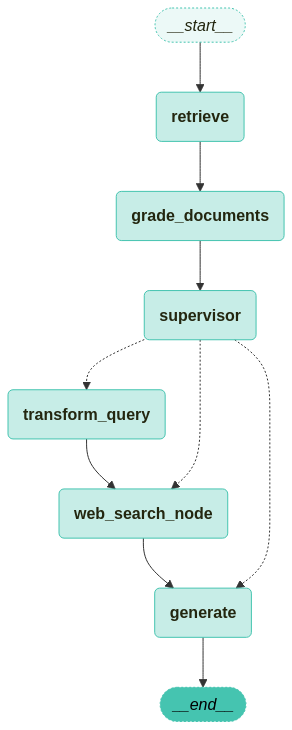

In [28]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)
